In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import cv2
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FeatureExtractor():
    def __init__(self,fft_len,hop_size,sr):
        self.fft_len=int(fft_len*sr//1000)
        self.hop_size=int(hop_size*sr//1000)
        self.sr= sr
        self.spec_dims=(160,32)
        self.fft_buff=np.zeros((self.fft_len,1))
        self.ifft_buff=np.zeros((self.fft_len,1))
        self.wnd=np.hanning(self.fft_len)
        self.zbuf=np.zeros((self.hop_size,1))
        self.specgram=np.zeros((self.spec_dims[0],self.spec_dims[1]))

    def stft(self,x):
        R=self.hop_size
        M= self.fft_len
        x=x.reshape((x.shape[0],-1))
        self.fft_buff[M-R:,:]=x
        xw=np.multiply(self.fft_buff.T,self.wnd)
        fft_xw=np.fft.fft(xw,n=M).T
        self.fft_buff[:M-R,:]=self.fft_buff[R:,:]
        return fft_xw

    def istft(self,x):
        R=self.hop_size
        M= self.fft_len
        iift_xw= np.fft.ifft(x.T,self.fft_len)
        y=self.ifft_buff[:R]
        self.ifft_buff[:M-R]=self.ifft_buff[R:]
        self.ifft_buff[M-R:]=self.zbuf
        self.ifft_buff=self.ifft_buff+iift_xw.T
        return y.real
    
    def spectrogram(self,fft_x):
        self.specgram[:,:-1]=self.specgram[:,1:]
        self.specgram[:,-1]=np.abs(fft_x)[:self.spec_dims[0],0]
        y=cv2.normalize(self.specgram, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #y=np.flip(y,0)
        return y
    

In [3]:
class DAPSDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        fft_len=40
        hop_len=10
        self.ftextr=FeatureExtractor(fft_len=fft_len,hop_size=hop_len,sr=8000)
        self.dir= "./daps_dict_unet2.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=2
        self.keys={}
        for key  in self.dataset_dict.keys():
            if(key=="produced"):
                self.keys[1]=key
            else:
                self.keys[indx]=key
                indx+=1

        self.num_files_per_category=len(self.dataset_dict["produced"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,isLabel=False):
        if(isLabel):
            category=self.keys[1]
        else:
            #category=self.keys[np.random.randint(2,len(self.keys))]
            #consider one category for now
            category=self.keys[3]
        data=cv2.imread(self.dataset_dict[category][str(indx)],0)
        data= cv2.normalize(data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [4]:
class DAPS(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= DAPSDatasetHelper()

    def __getitem__(self, index):
        data,id=self.daps.get_indxd_file(index)
        label,id=self.daps.get_indxd_file(index,True)
        return (data,label)

    def __len__(self):
        return (len(self.daps.keys)-1)*self.daps.num_files_per_category

In [5]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
NUM_TRAIN=16000
NUM_VAL=2000
NUM_TEST=2000
print_every = 100
dataset_train = DAPS()
batch_size=8
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= DAPSDatasetHelper()


In [8]:
print(dataset_train.daps.keys)

{2: 'iphone_bedroom1', 3: 'iphone_balcony1', 4: 'ipad_confroom1', 5: 'clean', 6: 'iphone_livingroom1', 7: 'ipad_confroom2', 8: 'ipad_livingroom1', 9: 'cleanraw', 1: 'produced', 10: 'ipadflat_office1', 11: 'ipadflat_confroom1', 12: 'ipad_office1', 13: 'ipad_balcony1', 14: 'ipad_bedroom1', 15: 'sample', 16: 'ipad_office2'}


In [9]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=(3,3),stride=1,padding=1)
        #self.bnorm1=nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3),stride=1,padding=1)
        #self.bnorm2=nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class encoder(nn.Module):
    def __init__(self, c_list):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=(2,1),stride=(2,1))
        self.blocks = nn.ModuleList([block(c_list[i], c_list[i+1]) for i in range(len(c_list)-1)])

    def forward(self, x):
        filters = []
        for block in self.blocks:
            x = block(x)
            #print("conv output",x.shape)
            filters.append(x)
            x = self.pool(x)
            #print("pool output",x.shape)
        return filters


class decoder(nn.Module):
    def __init__(self, c_list):
        super().__init__()
        self.up_cov = nn.ModuleList([nn.ConvTranspose2d(c_list[i], c_list[i+1], kernel_size=(2,1), stride=(2,1))
                                                                    for i in range(len(c_list)-1)])
        self.conv_blocks = nn.ModuleList([block(c_list[i], c_list[i+1]) for i in range(len(c_list)-1)])
        

    def forward(self, x, features):    
        for i in range(len(self.conv_blocks)):
            x = self.up_cov[i](x)
           # print("up conv output",features[i].shape, x.shape)
            x = torch.cat([x, features[i]], dim=1)
            x = self.conv_blocks[i](x)
            #print("concat output",x.shape)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        c_list=[1, 16, 32, 64, 128]
        self.enc_blocks = encoder(c_list)
        self.dec_blocks = decoder(c_list[::-1][:-1])
        self.last_layer = nn.Conv2d(c_list[1], 1, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        filters = self.enc_blocks(x)
        x = self.dec_blocks(filters[-1], filters[::-1][1:])
        return self.last_layer(x)

In [10]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_SNR(yhat,y):
    yhat=yhat.cpu().detach().numpy()
    y=y.cpu().detach().numpy()
    loss= np.mean(10*np.log(np.abs(yhat-y)/y))
    loss=torch.from_numpy(loss)
    loss=loss.to(device=device,dtype=dtype)
    return loss

#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    loss=lossfn(yhat,y)
    return loss


In [11]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            x=x.unsqueeze(1)
            y=y.unsqueeze(1) 
            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*x
            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]
            mse+= lossfn(y,yhat)
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [12]:
print_every=1
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    lossfn=nn.L1Loss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (x, y) in enumerate(loader_train):
            
            #print(y.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            y=y.to(device=device, dtype=dtype)

            x=x.unsqueeze(1)
            y=y.unsqueeze(1) 

            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*x

            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]

            loss = Loss_MSE(yhat, y, lossfn)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()
            

        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, (running_loss/len(loader_train))))
            train_loss.append(running_loss/len(loader_train))
            #check_accuracy_part2(loader_val, model_fn, params)
            
        vloss=check_accuracy(loader_val,model,lossfn)
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [13]:
learning_rate = 1e-3

model = UNet()
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [14]:
batch_size = batch_size
summary(model, input_size=(batch_size, 1, 160, 32))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─encoder: 1                             --                        --
│    └─ModuleList: 2-1                   --                        --
├─decoder: 1                             --                        --
│    └─ModuleList: 2-2                   --                        --
│    └─ModuleList: 2-3                   --                        --
├─encoder: 1-1                           [8, 16, 160, 32]          --
│    └─ModuleList: 2-1                   --                        --
│    │    └─block: 3-1                   [8, 16, 160, 32]          2,480
│    └─AvgPool2d: 2-4                    [8, 16, 80, 32]           --
│    └─ModuleList: 2-1                   --                        --
│    │    └─block: 3-2                   [8, 32, 80, 32]           13,888
│    └─AvgPool2d: 2-5                    [8, 32, 40, 32]           --
│    └─M

In [139]:
(train_loss,val_loss)=train_model(model, optimizer, scheduler,200)


Epoch 0, Iteration 1999, loss = 0.1487
Checking accuracy on validation set
Validation loss is 0.11993668
Epoch 1, Iteration 1999, loss = 0.1347
Checking accuracy on validation set
Validation loss is 0.12024832
Epoch 2, Iteration 1999, loss = 0.1346
Checking accuracy on validation set
Validation loss is 0.12038387
Epoch 3, Iteration 1999, loss = 0.1346
Checking accuracy on validation set
Validation loss is 0.12040549
Epoch 4, Iteration 1999, loss = 0.1346
Checking accuracy on validation set
Validation loss is 0.12039772
Epoch 5, Iteration 1999, loss = 0.1346
Checking accuracy on validation set
Validation loss is 0.12038396
Epoch 6, Iteration 1999, loss = 0.1345
Checking accuracy on validation set
Validation loss is 0.120369405


KeyboardInterrupt: 

In [15]:
model_path= "./misc/model_masked.pth"
torch.save(model.state_dict(),model_path)
model=UNet()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
dataset=DAPSDatasetHelper()
test_index=18869
model.to(device="cpu")
img_test,_= dataset.get_indxd_file(test_index)
img_label,_= dataset.get_indxd_file(test_index,True)
img = torch.tensor(img_test)
img=img.unsqueeze(0)
img=img.unsqueeze(0)
img=img.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(img*img)
out=out.squeeze(0)
out=out.squeeze(0)
out=out*img_test

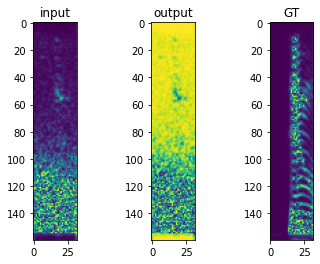

In [19]:
plt.figure()
ax1=plt.subplot(1,3,1)
ax1.imshow(img_test)
ax1.title.set_text("input")
ax2=plt.subplot(1,3,2)
ax2.imshow(out.cpu().numpy())
ax2.title.set_text("output")
ax3=plt.subplot(1,3,3)
ax3.imshow(img_label)
ax3.title.set_text("GT")

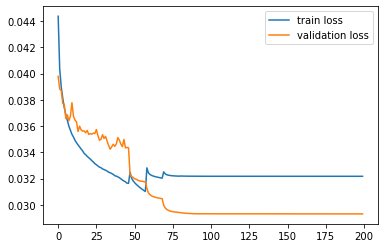

In [117]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss","validation loss"])

In [56]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

class LMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        y = np.dot(self.w.T,self.xd)
        
        e = d - y
        
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        
        self.w = self.w + Fw
    
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        return (y,e,w)


class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        #calculate error
        e = d - y
        #normalize by input energy
        e= e/(pw+0.0000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
        self.e=e

        #return current output sample, current error sample and current weights
        return (y,e,self.w)


Buffer level processing with 10ms of input samples being buffered and fed to the feature extractor in every iteration

In [118]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
block_size=80
frame_length=318
lmscls= NLMS(0.1,taps)
w=np.zeros((taps,1))
sr=8000

dirpath='../dataset/AEC-Challenge/datasets/synthetic/'
dirpath_daps='../dataset_daps/daps/'

total_duration=50*sr//block_size
hop_size=10
fft_len=39.75
ft= FeatureExtractor(fft_len=fft_len,hop_size=hop_size,sr=8000)
fft_mag=np.zeros((frame_length,1))

spects=[]
outs=[]
ifftlist=[]
ips=[]
for i in range(0,total_duration):
    #input,sr=librosa.load(dirpath+'/farend_speech/farend_speech_fileid_0.wav',sr=8000,duration=hop_size/1000, offset=i*hop_size/1000)
    input,sr=librosa.load(dirpath_daps+'/ipad_balcony1/f1_script1_ipad_balcony1.wav',sr=8000,duration=hop_size/1000, offset=i*hop_size/1000)
    GdT,sr=librosa.load(dirpath_daps+'/produced/f1_script1_produced.wav',sr=8000,duration=hop_size/1000, offset=i*hop_size/1000)
    ips.append(GdT)
    fft_ip=ft.stft(input)
    fft_phase= np.angle(fft_ip)
    spec=ft.spectrogram(fft_ip)
    spects.append(spec)
    img = torch.tensor(spec)
    img=img.unsqueeze(0).unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    
    out=out.squeeze(0).squeeze(0).cpu().numpy()
    out=out*spec
    outs.append(out)
    fft_out=out[:,-1]
    fft_out=fft_out.reshape(fft_out.shape[0],-1)
    fft_mag[:160,:]=fft_out
    fft_mag[160:,:]=np.flip(fft_mag[1:159,:],0)
    fft_y= np.multiply(fft_mag,np.exp( 1j * fft_phase ))
    ifft_ip=ft.istft(fft_y)
    ifftlist.append(ifft_ip)


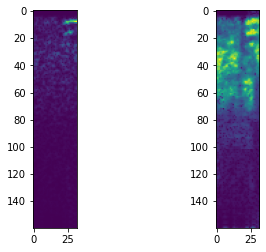

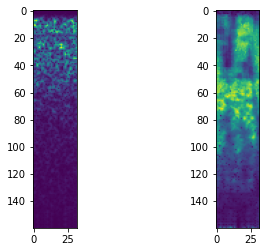

In [119]:
plt.figure()
ax4=plt.subplot(1,2,1)
ax4.imshow(spec)
ax4=plt.subplot(1,2,2)
ax4.imshow(out)
plt.figure()
ax4=plt.subplot(1,2,1)
ax4.imshow(spects[100])
ax4=plt.subplot(1,2,2)
ax4.imshow(outs[100])

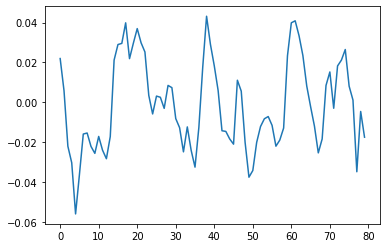

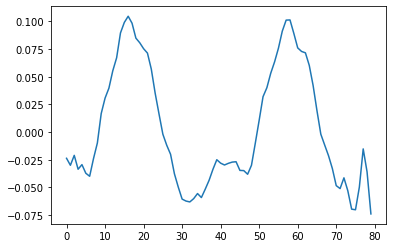

In [120]:
plt.figure()
plt.plot(ifft_ip)
plt.figure()
plt.plot(GdT)

In [121]:
out= np.array(ifftlist)
out=out.squeeze(-1)
out= out.reshape(out.shape[0]*out.shape[1],1)

ips= np.array(ips)
print(ips.shape)
ips= ips.reshape(out.shape[0]*out.shape[1],1)

(5000, 80)


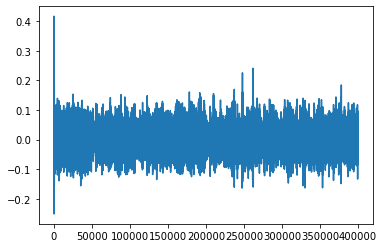

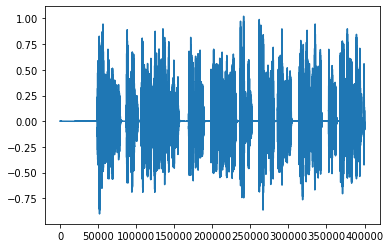

In [122]:
plt.figure()
plt.plot(out)
plt.figure()
plt.plot(ips)

In [174]:
wav.write("./out.wav", 8000, out)
wav.write("./ip.wav", 8000, ips)

In [123]:
input,sr=librosa.load(dirpath_daps+'/ipad_balcony1/f1_script1_ipad_balcony1.wav',sr=8000)

In [239]:
wav.write("./input.wav", 8000, input)

float32
(160, 17097)


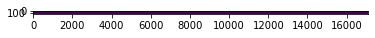

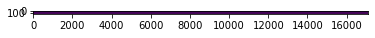

In [124]:
stftx=librosa.stft(input,n_fft=318,hop_length=80)

magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//32
specs=np.zeros_like(magstftx)
for i in range(0,segments):
    spec=magstftx[:,32*i:32*i+32]
    img = torch.tensor(spec)
    img=img.unsqueeze(0).unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0).squeeze(0).cpu().numpy()
    specs[:,32*i:32*i+32]=out*spec

specs=np.array(specs)
print(specs.dtype)

reconst=specs*phasex

plt.figure()
plt.imshow(magstftx)

plt.figure()
plt.imshow(specs)

print(stftx.shape)

istftx=librosa.istft(stftx,hop_length=80,n_fft=318)
reistftx=librosa.istft(reconst,hop_length=80,n_fft=318)

In [127]:
wav.write("./reconstructed.wav", 8000, reistftx)
print(np.max(spec))

2.7345896
